In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE = false

import logging
import time
import jax
import optax
import data
import dataclasses
import graph_transformer_model
import jraph
import metadata

import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
import haiku as hk
import typing as t
import jax.numpy as jnp
import numpy as np
import networkx as nx

from jax import lax
from datetime import datetime
# from tensorflow import summary


plt.rcParams['figure.figsize'] = [10, 5]
log_file_fmt_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
logging.basicConfig(filename=f"training_log_{log_file_fmt_str}.txt", level=logging.INFO)

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


### statics

In [3]:
# 36 is 3 hours, rounding up to the nearest power of 2 -> 64
BLOCK_SIZE = 32 # de facto it'll be x4 after byte encoding
BATCH_SIZE = 12
SPLIT = 0.85
LEARNING_RATE = 3e-4
SEED = 2137
NUM_TRAINING_STEPS = 25000
EVAL_INTERVAL = 500
EMBEDDING_SIZE = 4

SELF_EDGES = True
VOCAB_SIZE = 256
PAD_TOKEN = jnp.array(-1, dtype=jnp.int16)
GRAD_CLIP_VALUE = 1

NUM_LAYERS = 1
NUM_HEADS = 8  # Number of attention heads.

# based on https://proceedings.neurips.cc/paper/2020/file/ff4dfdf5904e920ce52b48c1cef97829-Paper.pdf
# MODEL_SIZE = exp(5.039) exp(0.0555 · NUM_LAYERS)
MODEL_SIZE = 64
KEY_SIZE = 8  # a.k.a HEAD_SIZE ~ NUM_HEADS * HEAD_SIZE = MODEL_SIZE
DROPOUT_RATE = 0.1
SOFTMAX_TEMP = 1.5
EMBEDDING_DTYPE = jnp.int16

LOAD_WEIGHTS = False

logging.info(f"Training params: MODEL_SIZE: {MODEL_SIZE}, " \
             f"NUM_LAYERS: {NUM_LAYERS}, " \
             f"NUM_HEADS: {NUM_HEADS}, " \
             f"KEY_SIZE: {KEY_SIZE}, " \
             f"DROPOUT_RATE: {DROPOUT_RATE}, " \
             f"SOFTMAX_TEMP: {SOFTMAX_TEMP}, " \
             f"LEARNING_RATE: {LEARNING_RATE}")

### utils

In [4]:
class TrainingState(t.NamedTuple):
  """Container for the training state."""
  params: hk.Params
  opt_state: optax.OptState
  rng: jax.Array
  step: jax.Array
    
class LoopValues(t.NamedTuple):
    logits: jnp.ndarray
    output_seq: jnp.ndarray

class Batch(t.NamedTuple):
    inputs: jraph.GraphsTuple
    targets: jraph.GraphsTuple

Metrics = t.MutableMapping[str, t.Any]

In [5]:
@jax.jit
def local_label_smoothing(arr: jnp.array, std: int = 2, mean: float = 0.7):
    # EXAMPLE: circular convolution
    # 
    # input: [0, 0, 1], in our case it will be always queal to VOCAB_SIZE
    # core: [.1, .8. .1]
    # 
    # [1, 0, 0 | 0, 0, 1 | 1, 0, 0]
    #   convolution into 
    # [.8, 0.1, 0 | 0, .1, .9 | .9, .1, 0]
    # return the middle
    conv_core = jnp.array([.05, .1, .7, .1, .05]) # [.01, .04, .9, .04, .01]
    vs = arr.shape[-1]
    arr = jnp.concatenate((jnp.flip(arr, axis=1), arr, jnp.flip(arr, axis=1)), axis=-1)
    convd = jnp.apply_along_axis(lambda x: jnp.convolve(conv_core, x, mode="same"), -1, arr)    
    return convd[..., VOCAB_SIZE:VOCAB_SIZE*2]

In [6]:
@jax.jit
def running_avg_smth(arr: jnp.array, alpha = 0.001) -> jnp.array:
    """
    the raw metrics values vary wildly, causing large jitter when plotted, 
    therefore we smooth it by using runnig average.
    
    TODO: rewrite using jax.scan(...)
    """
    res = jnp.zeros(arr.shape)
    for t in range(1, arr.shape[0]+1):
        lw = jnp.power(1 - alpha, t - jnp.arange(t))
        up = arr[:t] * lw
        res = res.at[t-1].set(up.sum()/lw.sum())
    return res

In [7]:
@jax.jit
def apply_byte_error_weights(arr: jnp.array):
    assert arr.shape[1] % EMBEDDING_SIZE == 0
    c = arr.shape[1] // EMBEDDING_SIZE
    
    # the first byte is virtually impossible to model as it's pure noise,
    # therefore we rescale the related error to have low impact on the loss
    weights = jnp.array([0.1, 0.5, 3., 4.] * c)
    return weights*arr

In [8]:
@jax.jit
def to_bytes(arr):
  """ Converts an array of uint32 into an array of bytes in little endian"""

  @ft.partial(jax.vmap, in_axes=(None, 0), out_axes=-1)
  def _to_bytes(arr, byte_index:int):
    mask = 0xFF << (8 * byte_index)
    b = (arr & mask) >> 8 * byte_index
    return  b.astype(EMBEDDING_DTYPE)

  return _to_bytes(arr, jnp.arange(4))

@ft.partial(jax.jit, static_argnames=("axis"))
def from_bytes(array, axis):
  """ Converts an array of bytes in little endian  into an array of uint32"""

  @ft.partial(jax.vmap, in_axes=(axis, -1))
  def _from_bytes(arr, byte_index):
    return arr << 8 * byte_index

  return jnp.sum(_from_bytes(array, jnp.arange(4)), axis=axis)

@jax.jit
def decode_bytes(arr: jnp.array) -> jnp.array:
    assert arr.shape[-1] % EMBEDDING_SIZE == 0
    mask = jnp.array([1, 256, 256*256, 256*256*256])
    
    w = arr.shape[-1] // EMBEDDING_SIZE
    res = arr.reshape((-1, w, EMBEDDING_SIZE))
    res = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, res)
    return res

### load data

In [9]:
sdl = data.SimpleDataLoader("../data/samples_5m_subset_v1.csv",
                            BLOCK_SIZE,
                            BATCH_SIZE,
                            EMBEDDING_SIZE,
                            SPLIT,
                            normalize=False,
                            log=False,
                            shift=False,
                            batch_first=True
                            )
train_di = sdl.get_graph_data_iter("train")
test_di = sdl.get_graph_data_iter("test")

In [10]:
expl_batch = next(train_di)
expl_batch["target"].shape

(12, 18, 32)

In [11]:
expl_batch['input'][0, 0, :4]

Array([18296, 18009, 19051, 19025], dtype=int32)

In [12]:
to_bytes(expl_batch['input']).shape, to_bytes(expl_batch['input'])[0, 0, :3, :]

((12, 18, 32, 4),
 Array([[120,  71,   0,   0],
        [ 89,  70,   0,   0],
        [107,  74,   0,   0]], dtype=int16))

### Utils

In [13]:
def get_alibi_mask() -> jax.Array:
    """
    ATTENTION WITH LINEAR BIASES - ALiBi positional embeddings 
    
    based on https://arxiv.org/pdf/2108.12409.pdf
    """
    seq_len = int(BLOCK_SIZE * EMBEDDING_SIZE)
    
    # there is a slope for each of the heads
    pwr = jnp.arange(NUM_HEADS) + 1
    slopes = jnp.power(2, -8/pwr)
    
    matrix = jnp.zeros((seq_len, seq_len), dtype=jnp.int32)
    
    # TODO: it's gross, rewrite
    for idx in range(seq_len):
        col1 = -jnp.arange(seq_len)
        col1 = jnp.pad(col1, (idx, 0))[:seq_len]
        matrix = lax.dynamic_update_slice(matrix, col1[:, None], (0, idx))
        
    sloped_matrix = jax.vmap(lambda s: s*matrix, out_axes = 0)(slopes)
    return sloped_matrix[None, ...] # [B=1, H, T, T]

alibi_mask = get_alibi_mask()

In [14]:
G = nx.from_numpy_array(jnp.array(metadata.ADJACENCY_MATRIX), create_using=nx.DiGraph)

# adding missing edges
G.add_edge(0, 1)  # cyfronet - uci
G.add_edge(0, 2)  # cyfronet - ftj
G.add_edge(5, 4)  # ms - b6

GRAPH_NUM_NODES = 18
GRAPH_NUM_EDGES = 80 if SELF_EDGES else 62
    
lin_G = nx.line_graph(G, create_using=nx.DiGraph)
logging.info(f"{lin_G.nodes.__len__()} nodes, {lin_G.edges.__len__()} edges in the Line Graph")

adj_matrix = jnp.array(metadata.LINE_GRAPH_ADJACENCY_MATRIX)
if SELF_EDGES:
    adj_matrix += jnp.eye(GRAPH_NUM_NODES)

lin_G_senders = []
lin_G_receivers = []

for x, row in enumerate(adj_matrix):
    for y, v in enumerate(row):
        if v:
            lin_G_senders.append(x)
            lin_G_receivers.append(y)

lin_G_senders = jnp.array(lin_G_senders)
lin_G_receivers = jnp.array(lin_G_receivers)
lin_G_senders.shape, lin_G_receivers.shape

((80,), (80,))

In [15]:
def get_graph_tuple(_nodes: jnp.array) -> jraph.GraphsTuple:
    assert _nodes.shape[0] == BATCH_SIZE and _nodes.shape[1] == GRAPH_NUM_NODES
    
    graphs_to_batch = []
    for i in range(BATCH_SIZE):
        graphs_to_batch.append(
            jraph.GraphsTuple(
                edges=jnp.zeros((GRAPH_NUM_EDGES, )),
                senders=lin_G_senders,
                receivers=lin_G_receivers,
                n_node=jnp.array([GRAPH_NUM_NODES]),
                n_edge=jnp.array([GRAPH_NUM_EDGES]),
                nodes=_nodes[i],
                globals=None
            )
        )
    return jraph.batch(graphs_to_batch)

@jax.jit
def preproc_data(batch: dict) -> jraph.GraphsTuple:
    _inputs = to_bytes(batch['input'])  # [B, Edg, T, Emb]
    _targets = to_bytes(batch['target'])  # [B, Edg, T, Emb]

    _inputs = _inputs.reshape((BATCH_SIZE, GRAPH_NUM_NODES, -1))
    _targets = _targets.reshape((BATCH_SIZE, GRAPH_NUM_NODES, -1))
    
    return Batch(
        inputs=get_graph_tuple(_inputs),
        targets=get_graph_tuple(_targets)
    )

In [16]:
_inputs = preproc_data(expl_batch)
_inputs.inputs.nodes.shape, _inputs.inputs.nodes.dtype

((216, 128), dtype('int16'))

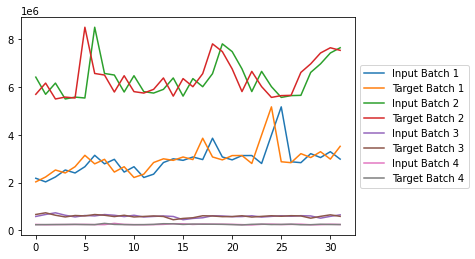

In [17]:
plt.figure()

plt.plot(expl_batch['input'][0, 4], label="Input Batch 1")
plt.plot(expl_batch['target'][0, 4], label="Target Batch 1")

plt.plot(expl_batch['input'][0, 1], label="Input Batch 2")
plt.plot(expl_batch['target'][0, 1], label="Target Batch 2")

plt.plot(expl_batch['input'][0, 2], label="Input Batch 3")
plt.plot(expl_batch['target'][0, 2], label="Target Batch 3")

plt.plot(expl_batch['input'][0, 3], label="Input Batch 4")
plt.plot(expl_batch['target'][0, 3], label="Target Batch 4")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

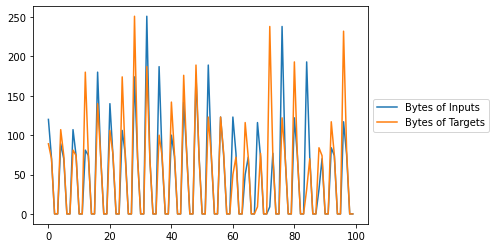

In [18]:
plt.figure()
plt.plot(_inputs.inputs.nodes[0, :100], label="Bytes of Inputs")
plt.plot(_inputs.targets.nodes[0, :100], label="Bytes of Targets")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### model

Based on Haiku's MultiheadAttention, Transformer Language model and jraph's GAT

In [115]:
def layer_norm(x: jax.Array) -> jax.Array:
    """Applies a unique LayerNorm to x with default settings."""
    ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
    return ln(x)


@dataclasses.dataclass
class GraphAttention(hk.Module):
    num_layers: int
    num_heads: int
    key_size: int
    alibi_mask: jnp.array
    widening_factor: int = 4
    dropout_rate: float = 0.1
    name: t.Optional[str] = None

    @hk.transparent
    def _linear_projection(
            self,
            x: jnp.ndarray,
            head_size: int,
            name: t.Optional[str] = None,
    ) -> jnp.ndarray:
        initializer = hk.initializers.VarianceScaling(2 / self.num_layers)
        y = hk.Linear(self.num_heads * head_size, w_init=initializer, name=name)(x)
        *leading_dims, _ = x.shape
        return y.reshape((*leading_dims, self.num_heads, head_size))

    def attention_query_fn(self, node_feat: jnp.array) -> jnp.array:
        """Function that generates attention queries from sender node features"""

        # our Value, Key and Query all have the same size :: K=V=Q
        query_heads = self._linear_projection(node_feat, self.key_size, "query")  # [T', H, Q=K]
        key_heads = self._linear_projection(node_feat, self.key_size, "key")  # [T, H, K]
        value_heads = self._linear_projection(node_feat, self.key_size, "value")  # [T, H, V]

        attn_logits = jnp.einsum("...thd,...Thd->...htT", query_heads, key_heads)
        attn_logits = self.alibi_mask + attn_logits / jnp.sqrt(self.key_size)

        seq_len = node_feat.shape[1]
        # masking future value for autoregressive predictions
        causal_mask = jnp.tril(jnp.ones((1, 1, seq_len, seq_len)))  # [B=1, H=1, T, T]
        attn_logits = jnp.where(causal_mask, attn_logits, -1e30)

        attn_weights = jax.nn.softmax(attn_logits)  # [H, T', T]
        # Weight the values by the attention and flatten the head vectors.
        attn = jnp.einsum("...htT,...Thd->...thd", attn_weights, value_heads)
        attn = jnp.reshape(attn, (attn.shape[0], attn.shape[1], -1))  # [T', H*V]

        return attn

    def attention_logit_fn(
            self,
            sender_feat: jnp.array,
            receiver_feat: jnp.array,
            edge_feat: jnp.array  # we store no data in the edges therefore it's skipped
    ) -> jnp.array:
        """Function that converts attention queries into logits for softmax attention"""
        initializer = hk.initializers.VarianceScaling(2 / self.num_layers)
        query_feat = jnp.concatenate((sender_feat, receiver_feat), axis=-1)

        spatial_attn = hk.Linear(sender_feat.shape[-1], w_init=initializer, name="spatial_attn")
        return spatial_attn(query_feat)

    def node_update_fn(self, node_feat: jnp.array) -> jnp.array:
        """function that updates the aggregated messages"""
        _, seq_len, model_size = node_feat.shape
        initializer = hk.initializers.VarianceScaling(2 / self.num_layers)

        dense_block = hk.Sequential([
            hk.Linear(self.widening_factor * model_size, w_init=initializer),
            jax.nn.gelu,
            hk.Linear(model_size, w_init=initializer),
        ])
        return dense_block(node_feat)

    def __call__(
            self,
            embedded_graph: jraph.GraphsTuple,  # [B x Edg, T x Emb, D]
            is_training = True
    ) -> jraph.GraphsTuple:

        def _ApplyGAT(graph):
            """Applies a Graph Attention layer."""
            nodes, edges, receivers, senders, _, _, _ = graph
            dropout_rate = self.dropout_rate if is_training else 0.
            
            # Equivalent to the sum of n_node, but statically known.
            try:
                sum_n_node = nodes.shape[0]
            except IndexError:
                raise IndexError('GAT requires node features')  # pylint: disable=raise-missing-from

            # Basically a transformer architecture without embeddings decoding
            nodes_norm = layer_norm(nodes)
            nodes_attn = self.attention_query_fn(nodes_norm)
            # final projection
            w_init = hk.initializers.VarianceScaling(2 / self.num_layers)
            model_size = nodes.shape[-1]
            final_projection = hk.Linear(model_size, w_init=w_init)
            nodes_attn = final_projection(nodes_attn)

            nodes_attn = hk.dropout(hk.next_rng_key(), dropout_rate, nodes_attn)
            nodes = nodes + nodes_attn

            nodes_norm = layer_norm(nodes)
            nodes_dense = self.node_update_fn(nodes_norm)
            nodes_dense = hk.dropout(hk.next_rng_key(), dropout_rate, nodes_dense)
            nodes = nodes + nodes_dense
            nodes = layer_norm(nodes)

            # We compute the softmax logits using a function that takes the
            # embedded sender and receiver attributes.
            sent_attributes = nodes[senders]  # [Edg x B, T, D]
            received_attributes = nodes[receivers]  # [Edg x B, T, D]
            softmax_logits = self.attention_logit_fn(
                sent_attributes, received_attributes, edges)

            # Compute the softmax weights on the entire tree.
            attn_weights = jraph.segment_softmax(softmax_logits, segment_ids=receivers,
                                                 num_segments=sum_n_node)  # [Edg x B, T x Emb, D]
                        
            spatial_q = self._linear_projection(
                attn_weights, attn_weights.shape[-1], "spatial_q")
            
            # messages = attn_weights * sent_attributes
            messages = jnp.mean(spatial_q * sent_attributes[..., None, :], axis = -2)
            
            # Aggregate messages to nodes.
            nodes = jraph.segment_sum(messages, receivers, num_segments=sum_n_node)
            # TODO: add final layer
            return graph._replace(nodes=nodes)

        return _ApplyGAT(embedded_graph)


@dataclasses.dataclass
class GraphTransformer(hk.Module):
    # dropout_rate: float
    model_size: int
    vocab_size: int
    graph_attention: GraphAttention
    embedding_size: int = 4
    name: t.Optional[str] = None

    def __call__(
            self,
            input_graph: jraph.GraphsTuple,  # [B x Edg, T x Emb]
            is_training = True
    ) -> jraph.GraphsTuple:  # [B x Edg, T x Emb]

        _, seq_len = input_graph.nodes.shape

        # embed byte values in the nodes
        # initializers parametrizes as suggested in https://arxiv.org/abs/2201.11990 :: std = sqrt(1/(D*3))
        embed_init = hk.initializers.RandomNormal(stddev=0.072)
        token_embedding_map = hk.Embed(
            self.vocab_size, embed_dim=self.model_size, w_init=embed_init)
        graph_embedded = jraph.GraphMapFeatures(
            embed_node_fn=token_embedding_map
        )(input_graph)  # [B x Edg, T x Emb, D]

        # add byte position embeddings
        _byte_position_embeddings = hk.get_parameter(
            'byte_position_embeddings', [self.embedding_size, self.model_size], init=embed_init)
        byte_position_embeddings = _byte_position_embeddings
        for _ in range((seq_len // self.embedding_size) - 1):
            byte_position_embeddings = jnp.concatenate(
                (byte_position_embeddings, _byte_position_embeddings), axis=0)
        graph_embedded = jraph.GraphMapFeatures(
            embed_node_fn=lambda x: x + byte_position_embeddings
        )(graph_embedded)  # [B x Edg, T x Emb, D]
        
        for i in range(self.embedding_size): 
            graph_embedded = self.graph_attention(graph_embedded, is_training=is_training)
            graph_embedded = graph_embedded._replace(nodes=graph_embedded.nodes)

        # decode the embeddings
        out_graph = jraph.GraphMapFeatures(
            embed_node_fn=hk.Linear(self.vocab_size)
        )(graph_embedded)  # [B x Edg, T x Emb]
        return out_graph


In [116]:
def forward(tokens: t.Union[np.ndarray, jax.Array], is_training=True) -> jax.Array:
    net = GraphTransformer(
        model_size=MODEL_SIZE,
        vocab_size=VOCAB_SIZE,
        graph_attention= GraphAttention(
            num_layers=NUM_LAYERS,
            num_heads=NUM_HEADS,
            key_size=KEY_SIZE,
            alibi_mask=alibi_mask,
        ),
    )
    return net(tokens, is_training)

### training

In [164]:
# Create the optimiser.
optimiser = optax.chain(
  optax.clip_by_global_norm(GRAD_CLIP_VALUE),
  optax.adamw(LEARNING_RATE, b1=0.9, b2=0.95, weight_decay=0.1),
)

# Create the loss.
@hk.transform
def loss_fn(batch: Batch) -> t.Tuple[jax.Array, Metrics]:
    """Computes the (scalar) loss on `data` w.r.t. params."""
    inp = batch.inputs
    out = batch.targets
    print(inp.nodes.shape)
    result_graph: jraph.GraphsTuple = forward(inp)
    logits = result_graph.nodes
    
    # this mask excludes -1's which we use as a padding in an input seq
    input_mask = jnp.greater(inp.nodes, jnp.array(-1, dtype=jnp.int16))
    targets = jax.nn.one_hot(out.nodes, VOCAB_SIZE)  # (B, T*D, V)
    
    ### LOCAL LABEL SMOOTHING ###
    targets = local_label_smoothing(targets)
    
    assert logits.shape == targets.shape
    
    log_sft = jax.nn.log_softmax(logits / SOFTMAX_TEMP)
    log_likelihood = jnp.sum(targets * log_sft, axis=-1) # (B, T)
    
    predictions = jnp.argmax(log_sft, axis=-1) # (B, T)
    #  neighbouring classes are similar therefore we use calculate accuracy 
    #  for the closes 1 and 2 heighbours as well
    out = out.nodes.astype(jnp.int32) # convert to signed int in order to make correct comparisons
    acc = jnp.asarray(predictions == out).reshape((-1, BLOCK_SIZE, 4))
    acc3 = jnp.logical_and(predictions <= out + 1, predictions >= out - 1)
    acc3 = acc3.reshape((-1, BLOCK_SIZE, 4))
    acc5 = jnp.logical_and(predictions <= out + 2, predictions >= out - 2)
    acc5 = acc5.reshape((-1, BLOCK_SIZE, 4))
    
    mae = jnp.mean(jnp.abs(decode_bytes(predictions) - decode_bytes(out)))
    
    # (out [B, T], predictions [B, T]) -> [E, E]
    confusion_matrix = jnp.matmul(jnp.transpose(jax.nn.one_hot(out, VOCAB_SIZE), (0, 2, 1)), 
                                  jax.nn.one_hot(predictions, VOCAB_SIZE))
    
    metrics = {
        'accuracy': acc.mean(axis=(0, 1)),
        'accuracy_3': acc3.mean(axis=(0, 1)),
        'accuracy_5': acc5.mean(axis=(0, 1)),
        'conf_mat': confusion_matrix,
        'mae' : mae
    }
        
    log_likelihood = jnp.sum(targets * jax.nn.log_softmax(logits / SOFTMAX_TEMP), axis=-1)
    ### BYTE-LEVEL ERROR SCALING ###
    # the last token is the first byte of the prediction
    # it's scaled by 1.0, so we can skip it and it would have the same effect
    log_likelihood = apply_byte_error_weights(log_likelihood)
    return -jnp.sum(log_likelihood * input_mask) / jnp.sum(input_mask), metrics  # NLL per token.

@jax.jit
def update(state: TrainingState, batch) -> t.Tuple[TrainingState, Metrics]:
    """Does an SGD step and returns metrics."""
    rng, new_rng = jax.random.split(state.rng)
    loss_and_grad_fn = jax.value_and_grad(loss_fn.apply, has_aux=True)
    (loss, metrics), gradients = loss_and_grad_fn(state.params, rng, batch)

    updates, new_opt_state = optimiser.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng=new_rng,
        step=state.step + 1,
    )

    metrics.update({
        'step': state.step,
        'loss': loss,
    })
    return new_state, metrics

model initialization

In [165]:
rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)
init_batch = preproc_data(expl_batch)
initial_params = loss_fn.init(init_rng, init_batch)

initial_opt_state = optimiser.init(initial_params)
initial_state =  TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng=init_rng,
    step=jnp.array(0),
)

(216, 128)


metrics

In [82]:
num_params = 0
for l in initial_state.params:
    for p in initial_state.params[l]:
        num_params += initial_state.params[l][p].size

logging.info(f"Model size: {num_params}")

In [83]:
metrics_avg: Metrics = {}

def record_metrics(metrics: t.Mapping):
    for k, v in metrics.items():
        v = jnp.expand_dims(v, -1)
        if k in metrics_avg:
            metrics_avg[k] = jnp.concatenate((metrics_avg[k], v), axis=-1)
        else:
            metrics_avg[k] = v

In [84]:
class TensorBoard:
    def __init__(self, logdir):
        self.logdir = logdir
        if not os.path.exists(self.logdir):
            os.makedirs(self.logdir)
        self.writer = tf.summary.create_file_writer(self.logdir)

    def scalar(self, name, data, step):
        with self.writer.as_default():
            tf.summary.scalar(name, data, step)

training loop

In [87]:
if LOAD_WEIGHTS:
    model_params = jnp.load('graph_transformer_2023-04-11-13-08-17.npy', allow_pickle=True)
else:
    avg_loss = []
    confusion_matrix = jnp.zeros((GRAPH_NUM_NODES*BATCH_SIZE, VOCAB_SIZE, VOCAB_SIZE))
    prev_time = time.time()
    training_start_ts = time.time()
    state = initial_state
    for step in range(NUM_TRAINING_STEPS + 1):
        batch = preproc_data(next(train_di))
        state, metrics = update(state, batch)
        # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
        # Using values from state/metrics too often will block the runahead and can
        # cause these overheads to become more prominent.
        
        #
        if step % EVAL_INTERVAL == 0:
            steps_per_sec = EVAL_INTERVAL / (time.time() - prev_time)
            prev_time = time.time()
            rng, new_rng = jax.random.split(rng)
            valid_loss, _ = loss_fn.apply(state.params, new_rng, preproc_data(next(test_di))) 
            
            metrics.update({'steps_per_sec': steps_per_sec, 'valid_loss': valid_loss})
            
            confusion_matrix = confusion_matrix + metrics['conf_mat']
            
            # record_metrics(metrics)
            
            logging.info(f"{(time.time() - training_start_ts)/60:0.1f} min, " \
                  f"Step: {step}, " \
                  f"Loss: {metrics['loss']:.2f}, " \
                  f"Vloss: {metrics['valid_loss']:.2f}, " \
                  f"Acc: {[f'{i:0.2f}' for i in metrics['accuracy']]}, " \
                  f"Acc3: {[f'{i:0.2f}' for i in metrics['accuracy_3']]}, " \
                  f"MAE: {metrics['mae']:.2f}, " \
                  f"") 
            print(f"{(time.time() - training_start_ts)/60:0.1f} min | " \
                  f"step: {step} | " \
                  f"loss: {metrics['loss']:.2f} | " \
                  f"vloss: {metrics['valid_loss']:.2f} | " \
                  f"acc3: {[f'{i:0.2f}' for i in metrics['accuracy_3']]}"
                 )
            
    final_params = state.params

0.0 min | step: 0 | loss: 9.84 | vloss: 9.59 | acc3: ['0.01', '0.01', '0.01', '0.00']
0.8 min | step: 500 | loss: 4.25 | vloss: 4.25 | acc3: ['0.01', '0.13', '0.46', '0.96']
1.5 min | step: 1000 | loss: 4.23 | vloss: 4.07 | acc3: ['0.01', '0.14', '0.42', '0.97']
2.3 min | step: 1500 | loss: 4.13 | vloss: 4.20 | acc3: ['0.01', '0.14', '0.44', '0.97']
3.0 min | step: 2000 | loss: 3.97 | vloss: 3.88 | acc3: ['0.01', '0.15', '0.45', '0.97']
3.8 min | step: 2500 | loss: 3.91 | vloss: 3.81 | acc3: ['0.01', '0.16', '0.47', '0.96']
4.5 min | step: 3000 | loss: 3.85 | vloss: 3.79 | acc3: ['0.01', '0.17', '0.47', '0.97']
5.3 min | step: 3500 | loss: 3.69 | vloss: 3.70 | acc3: ['0.01', '0.17', '0.48', '0.99']
6.0 min | step: 4000 | loss: 3.54 | vloss: 3.83 | acc3: ['0.01', '0.18', '0.51', '0.99']
6.8 min | step: 4500 | loss: 3.66 | vloss: 3.74 | acc3: ['0.01', '0.16', '0.50', '0.99']
7.5 min | step: 5000 | loss: 3.63 | vloss: 3.71 | acc3: ['0.01', '0.16', '0.50', '0.99']
8.3 min | step: 5500 | lo

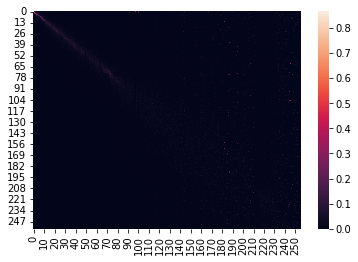

In [88]:
if not LOAD_WEIGHTS:
    sns.heatmap(confusion_matrix.sum(0)/(confusion_matrix.sum((0,1)) + 1))

In [ ]:
if not LOAD_WEIGHTS:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(metrics_avg['step'], running_avg_smth(metrics_avg['loss']), 
             label = "Training loss")
    ax1.plot(metrics_avg['step'], running_avg_smth(metrics_avg['valid_loss']),
             label = "Validation loss")
    ax1.set(xlabel='Steps', ylabel='Training loss')
    ax1.legend()

    ax2.plot(metrics_avg['step'], running_avg_smth(metrics_avg['accuracy_3'][0][:-1]), 
                                                   label = "Accuracy 3, 1'st byte")
    ax2.plot(metrics_avg['step'], running_avg_smth(metrics_avg['accuracy_3'][1][:-1]), 
                                                   label = "Accuracy 3, 2'nd byte")
    ax2.plot(metrics_avg['step'], running_avg_smth(metrics_avg['accuracy_3'][2][:-1]), 
                                                   label = "Accuracy 3, 3'rd byte")
    ax2.plot(metrics_avg['step'], running_avg_smth(metrics_avg['accuracy_3'][3][:-1]), 
                                                   label = "Accuracy 3, 4'th byte")
    ax2.set(xlabel='Steps', ylabel='Accuracy 3')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.show()
    plt.savefig(f"training_metrics_{log_file_fmt_str}.svg")

### validation

In [90]:
if LOAD_WEIGHTS:
    model_weights = model_params.item()
else:
    model_weights = state.params

save model weights

In [91]:
weights_file_name = f"graph_transformer_{log_file_fmt_str}.npy"

if not LOAD_WEIGHTS:
    with open(weights_file_name, 'wb') as f:
        jnp.save(f, state.params)
        
logging.info(f"Model saved as {weights_file_name}")

In [119]:
@hk.transform
def generate(context: jraph.GraphsTuple, _seq_len: int) -> jnp.array:
    output_seq = jnp.zeros((BATCH_SIZE * GRAPH_NUM_NODES, _seq_len, 4))

    def body_fn(idx: int, v: LoopValues) -> LoopValues:
        output_graph = forward(v.logits, is_training=False)  # (B, T*D, 256)
        new_logits = jax.random.categorical(hk.next_rng_key(), output_graph.nodes, axis=-1).astype(jnp.int16)  # (B x Edg, T)
        new_output_seq = v.output_seq.at[:, idx, :].set(new_logits[:, -4:])
        new_input_graph = output_graph._replace(nodes = new_logits)
        return LoopValues(logits=new_input_graph, output_seq=new_output_seq)
        
    initial_values = LoopValues(logits=context, output_seq=output_seq)
    lv: LoopValues = hk.fori_loop(0, _seq_len, body_fn, initial_values) 
    mask = jnp.array([1, 256, 256*256, 256*256*256])
    return jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, lv.output_seq)

@hk.transform
def generate_full_seq(context: jraph.GraphsTuple) -> jnp.array:
    inp = context
    output_graph = forward(inp, is_training=False)  # (B, T*D, 256)
    logits = output_graph.nodes
    
    logits = jax.random.categorical(hk.next_rng_key(), logits, axis=-1)
    res = decode_bytes(logits)
    return res, logits

In [178]:
rng = hk.PRNGSequence(SEED)

In [150]:
test_batch = preproc_data(next(test_di))

_predictions, lg = generate_full_seq.apply(model_weights, next(rng), test_batch.inputs)
_predictions.shape

(216, 32)

In [151]:
context = decode_bytes(test_batch.targets.nodes)
context.shape

(216, 32)

In [152]:
print(f"MAE ... {jnp.mean(jnp.abs(_predictions - context))}")

MAE ... 2638292.25


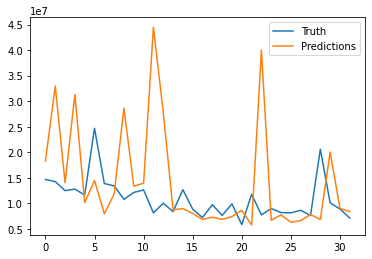

In [153]:
plt.figure()
# plt.plot(context[0] + 2**16, label="error margin", color="red")
# plt.plot(context[0] - 2**16, label="error margin", color="red")
plt.plot(context[10], label="Truth")
plt.plot(_predictions[10], label="Predictions")
plt.legend()
plt.show()

In [125]:
predictions = generate.apply(model_weights, next(rng), test_batch.inputs, 580) # 580 samples is about 2 days
predictions.shape

(216, 580)

In [126]:
target = decode_bytes(test_batch.targets.nodes)
target.shape

(216, 32)

we draw additional error margins corresponding to the maximum error from the first two bytes

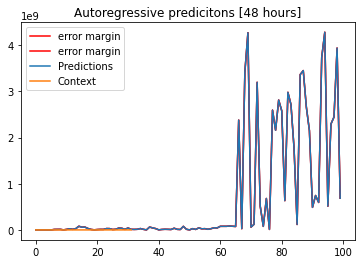

In [127]:
edg_idx = 200

plt.figure()
plt.plot(predictions[edg_idx, :100] + 2**16, label="error margin", color="red")
plt.plot(predictions[edg_idx, :100] - 2**16, label="error margin", color="red")
plt.plot(predictions[edg_idx, :100], label="Predictions")
plt.plot(target[edg_idx], label="Context")
plt.legend()
plt.title("Autoregressive predicitons [48 hours]")
plt.show()

entire test sequence predictions

In [179]:
test_data_full = sdl.edges_test_data  # (E, NUM_TEST_SAMPLES)
print(test_data_full.shape)

(18, 24341)


In [180]:
# split test_data_full into N batches -> (B, Edg, T)
tail = test_data_full.shape[1] % (BLOCK_SIZE*EMBEDDING_SIZE*BATCH_SIZE)
test_data_full = test_data_full[:, :-tail]
test_data_full = to_bytes(test_data_full)
test_data_full = test_data_full.reshape((GRAPH_NUM_NODES, -1))
test_data_full = test_data_full.reshape((GRAPH_NUM_NODES, BATCH_SIZE, -1))
test_data_full = test_data_full.transpose((1, 0, 2))
print(test_data_full.shape)

# split into inference batches -> (B, Edg, T, N) 
N = test_data_full.shape[-1] // (BLOCK_SIZE*EMBEDDING_SIZE)
test_data_full = test_data_full.reshape(
    (BATCH_SIZE, GRAPH_NUM_NODES, N, -1)).transpose((0, 1, 3, 2))
print(test_data_full.shape)
print(test_data_full[0, 0, :16, 0])

(12, 18, 7680)
(12, 18, 128, 60)
[ 60  86   0   0  31  86   0   0 229  82   0   0  25  88   0   0]


In [181]:
@jax.jit
def genereate_fn(w, rng, arr: jnp.array) -> jraph.GraphsTuple:
    input_graph = get_graph_tuple(arr)
    return generate_full_seq.apply(w, rng, input_graph)

ys = []
for i in range(test_data_full.shape[-1]):
    preds, log = genereate_fn(model_weights, next(rng), test_data_full[..., i])
    ys.append(preds)

full_seq_predictions = jnp.stack(ys, axis=-1)
full_seq_predictions.shape

(216, 32, 60)

In [182]:
v_decode_bytes = jax.vmap(decode_bytes, -1, -1)
test_data_full_decoded = v_decode_bytes(test_data_full)
test_data_full_decoded.shape

(216, 32, 60)

In [183]:
full_seq_predictions[200, :, 4]

Array([   52543,    19967,    60856,     2815,     9019,     2368,
           3469,     2478,    65029,     3114,     2481,    65535,
       16779519, 16842751,   132988,    65355,     3067,     2559,
           2559,     2987,     3036,     4266,     3071,     2109,
          65428,     2046,    11644,    65477,     3683,     2559,
           3838,     1855], dtype=int32)

In [184]:
jnp.mean(jnp.abs(test_data_full_decoded[:, 1:] - full_seq_predictions[:, :-1]))

Array(2964087.2, dtype=float32)

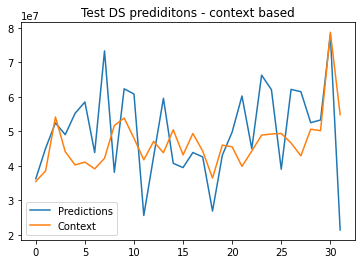

In [208]:
rnd_sample_idx = jax.random.randint(next(rng), (1, ), 0, test_data_full_decoded.shape[-1]).item()
edg_idx = jax.random.randint(next(rng), (1, ), 0, test_data_full_decoded.shape[0]).item()

plt.figure()
plt.plot(full_seq_predictions[edg_idx, :, rnd_sample_idx], label="Predictions")
plt.plot(test_data_full_decoded[edg_idx, :, rnd_sample_idx], label="Context")
plt.legend()
plt.title("Test DS prediditons - context based")
plt.show()

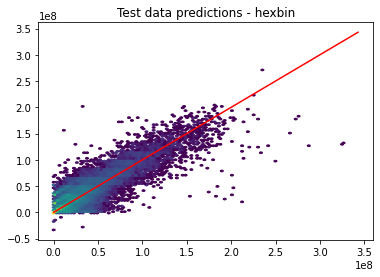

In [223]:
fig, ax = plt.subplots()
ax.hexbin(x = jnp.ravel(test_data_full_decoded[:, 1:]), y = jnp.ravel(full_seq_predictions[:, :-1]),
        bins = "log")

lims = [
    np.min([0, 0]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'r-')
plt.title("Test data predictions - hexbin")
plt.show()

In [239]:
jnp.abs(errs).std(), jnp.abs(errs).mean()

(Array(7103986.5, dtype=float32), Array(2964087.2, dtype=float32))

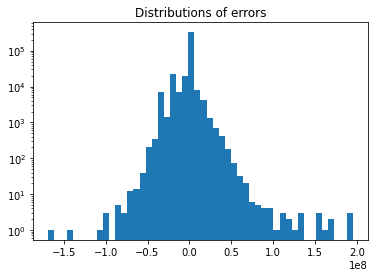

In [238]:
errs = (test_data_full_decoded[:, 1:] - full_seq_predictions[:, :-1]).ravel()

fig, ax = plt.subplots()
ax.hist(errs, bins=50, log=True)
plt.title("Distributions of errors")
plt.show()